In [1]:
## Importing libraries

In [3]:
# Utils
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import clear_output as cls
import imutils
import zipfile

# Modeling
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D as GAP
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# pre-trained model
from keras.applications import ResNet50V2

In [5]:
# Unzipping data on Colab
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [6]:
# defining main directory
main_directory = 'brain_tumor_dataset/'
# checkin classes names
class_names = sorted(os.listdir(main_directory))
# checking number of classes
n_classes = len(class_names)

# class distribution
class_diss = [len(os.listdir(main_directory + name)) for name in class_names]
print(f"Total Number of classes : {n_classes} \nClasse Names : {class_names}")

Total Number of classes : 2 
Classe Names : ['no', 'yes']


In [7]:
# Visualizing class distribution
fig = px.pie(names=class_names, values=class_diss, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

**# Images preprocessing**

In [8]:
def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [9]:
# resizing and cropping images
subdir_list = os.listdir(main_directory)

target_size = (630, 630)

for subdir in subdir_list:
    subdir_path = os.path.join(main_directory, subdir)
    if os.path.isdir(subdir_path):
        image_list = os.listdir(subdir_path)
        for image_name in image_list:
            # read image
            image = cv2.imread(os.path.join(subdir_path, image_name))
            # resize image
            image = cv2.resize(image, target_size)
            # crop image
            image = crop_brain_contour(image)
            # replacing the old image in directory
            cv2.imwrite(os.path.join(subdir_path, image_name), image)

**Loading data**

In [10]:
# data loading and augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             rescale=1./255,
                             shear_range=0.05,
                             brightness_range=[0.1, 1.5],
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.3)

# loading training set
train = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='training')

# loading validation set
validation = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='validation')

Found 178 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [11]:
def show_images(GRID= [5,5], model=None, size = (20,20), data=train):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_rows * n_cols

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

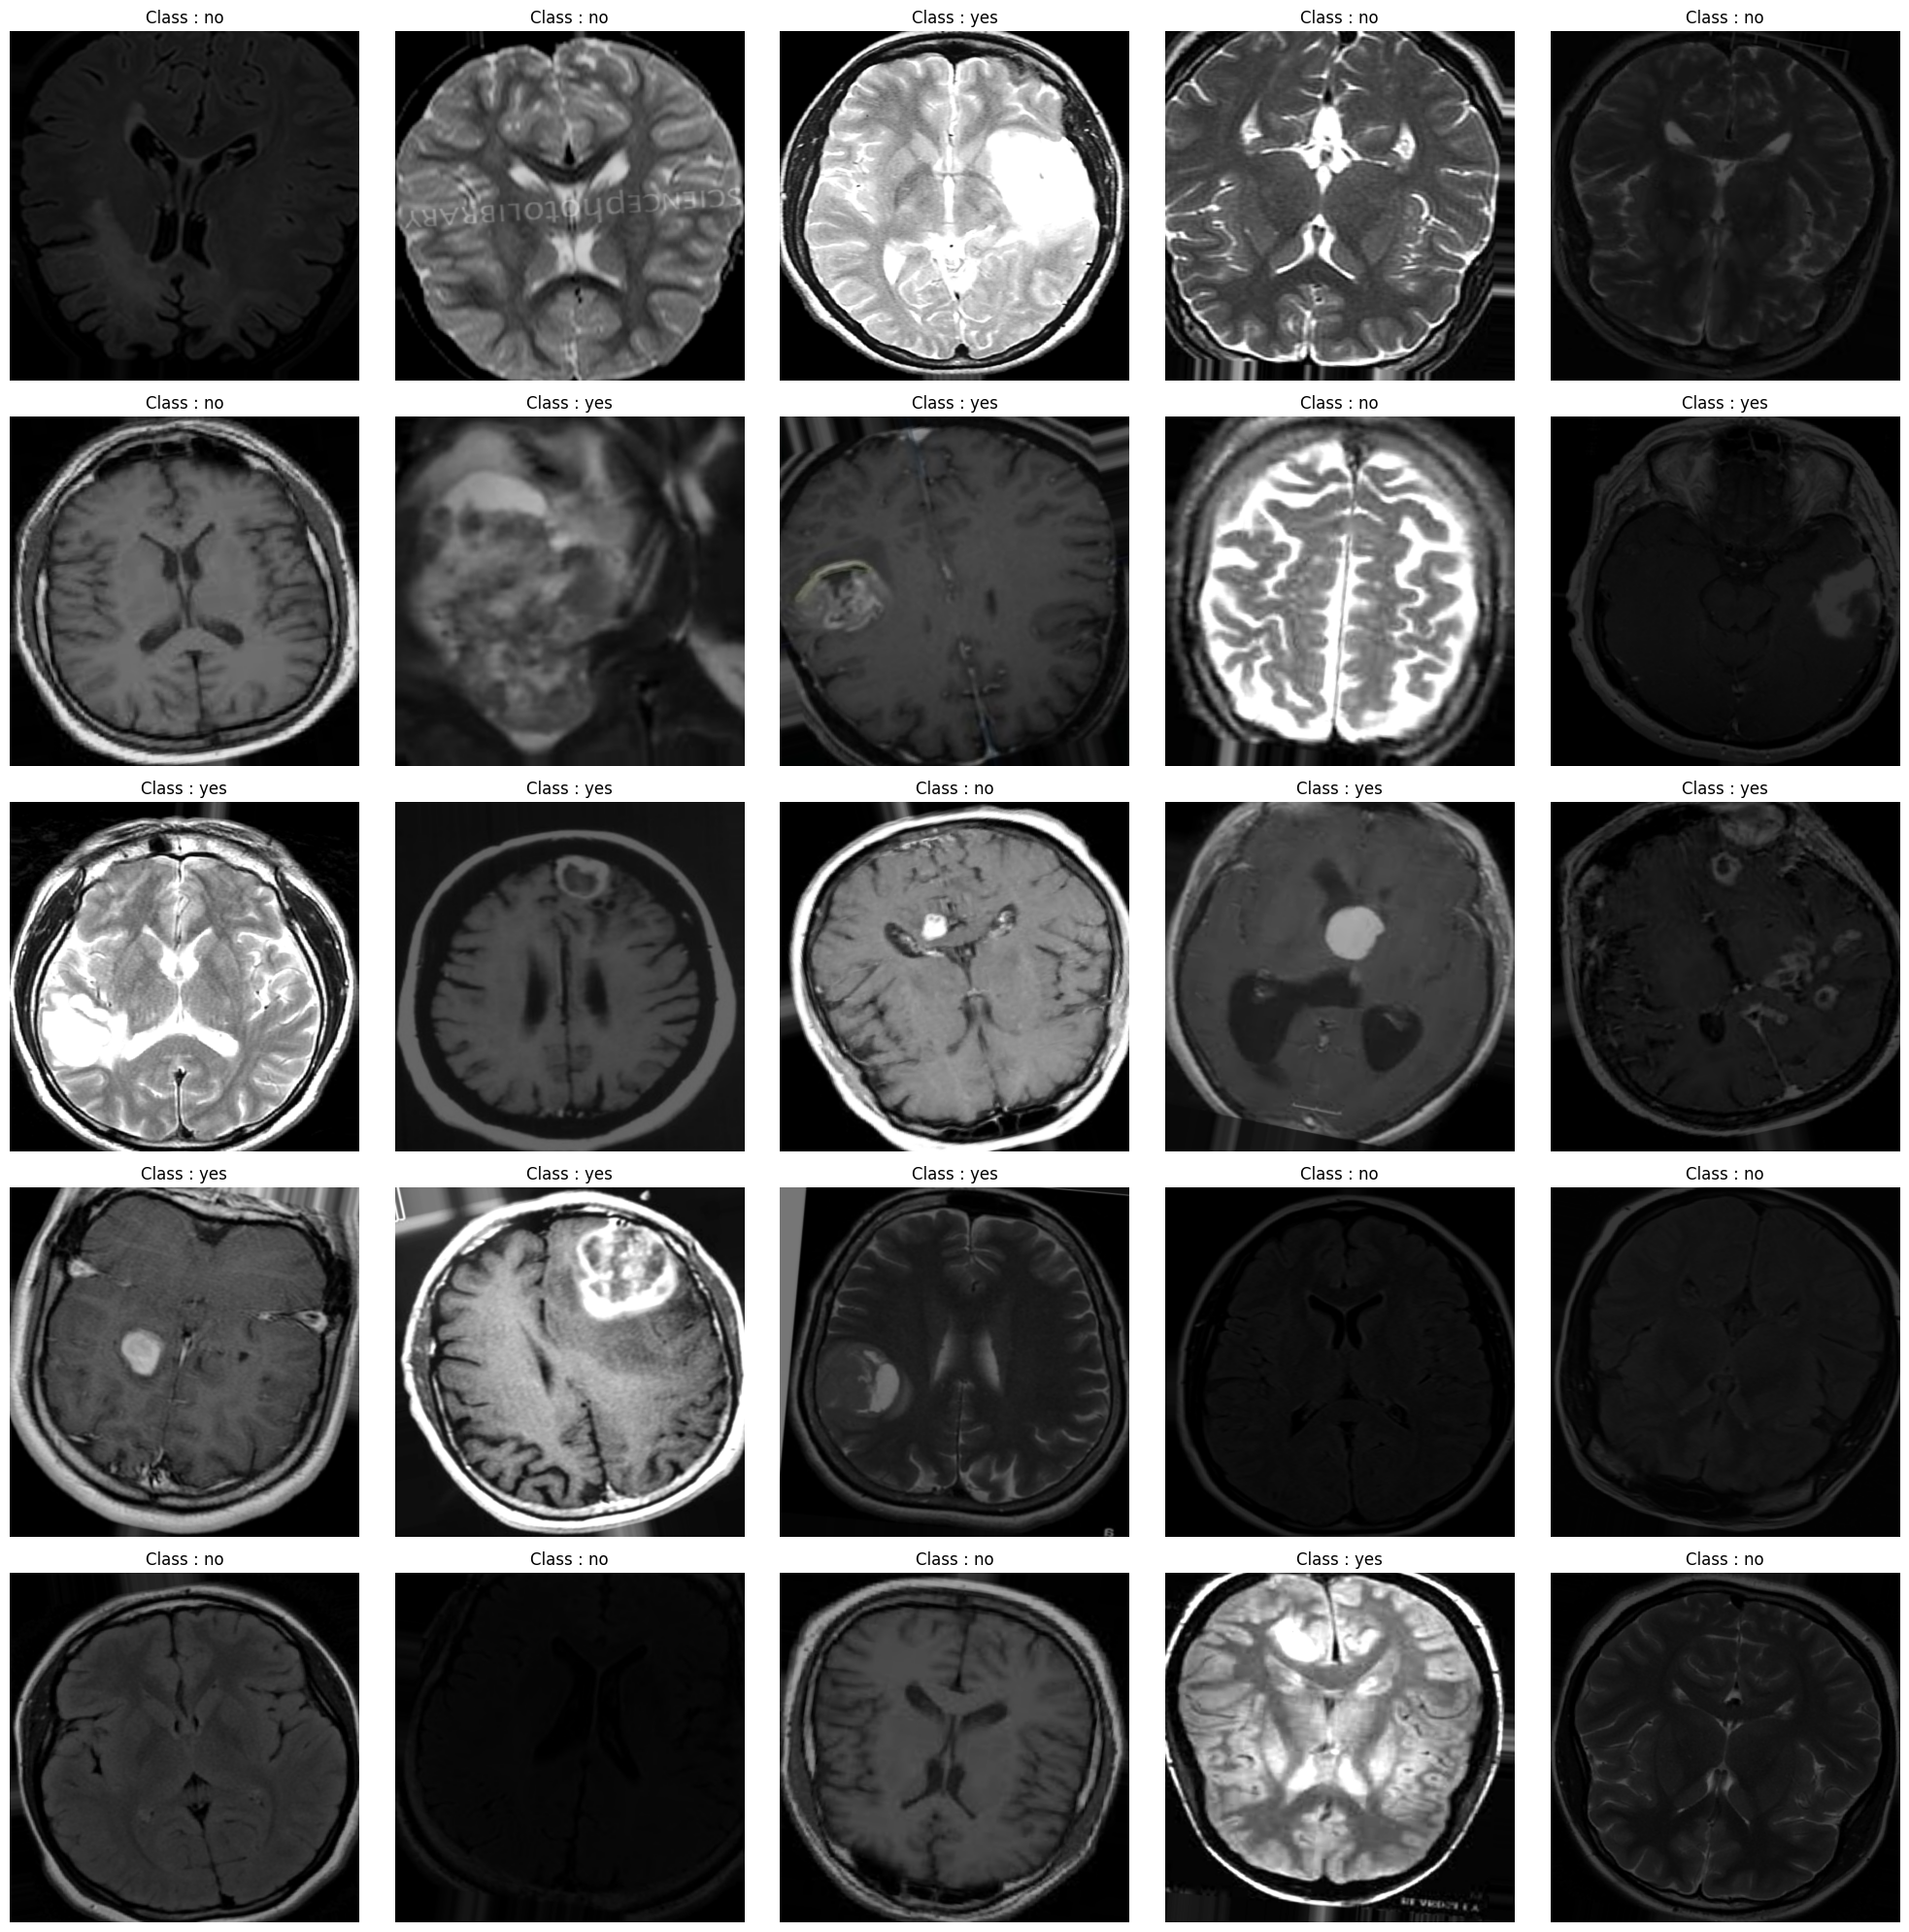

In [12]:
show_images()

**Training**

In [13]:
# defining the base pre-trained model
base_model = ResNet50V2(input_shape=(630,630,3), include_top=False)
base_model.trainable = False

# defining our model
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax'),
], name=name)

# compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training model
history = model.fit(train, validation_data=validation, epochs=30)

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/30
12/12 [==============================] - 59s 3s/step - loss: 1.0734 - accuracy: 0.5787 - val_loss: 0.7784 - val_accuracy: 0.5600
Epoch 2/30
12/12 [==============================] - 35s 3s/step - loss: 0.4887 - accuracy: 0.7472 - val_loss: 0.4034 - val_accuracy: 0.8133
Epoch 3/30
12/12 [==============================] - 34s 3s/step - loss: 0.4061 - accuracy: 0.8202 - val_loss: 0.4139 - val_accuracy: 0.8267
Epoch 4/30
12/12 [==============================] - 33s 3s/step - loss: 0.3584 - accuracy: 0.8596 - val_loss: 0.2803 - val_accuracy: 0.9067
Epoch 5/30
12/12 [==============================] - 33s 3s/step - loss: 0.3190 - accuracy: 0.8596 - val_loss: 0.3528 - val_accuracy: 0.8800
Epoch 6/30
12/12 [==============================] - 34s 3s/step - loss: 0.4121 - accuracy: 0.8146 - val_loss: 0.3768 - val_accuracy: 0.8533
Epoch 7/30
12/12 [==============================] - 35s 3s/step - loss: 0.3003 - accuracy: 0.87

**Evalutaion**

In [14]:
# train history
data = pd.DataFrame(history.history)
data[-5:]

loss  accuracy  val_loss  val_accuracy
25  0.124119  0.955056  0.356691      0.853333
26  0.079008  0.966292  0.387399      0.866667
27  0.194790  0.898876  0.432972      0.826667
28  0.110339  0.949438  0.340972      0.826667
29  0.109916  0.966292  0.409878      0.826667

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4567267904262762377, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4567267904262762377, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4567267904262762377, *['val_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4567267904262762377, *['val_accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4567267904262762377, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4567267904262762377, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4567267904262762377, *['val_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4567267904262762377, *['val_accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4567267904262762377 = autoviz.get_registered_df('df_4567267904262762377')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_4567267904262762377, *[[['loss', 'accuracy'], ['accuracy', 'val_loss'], ['val_loss', 'val_accuracy']]], **{})
chart

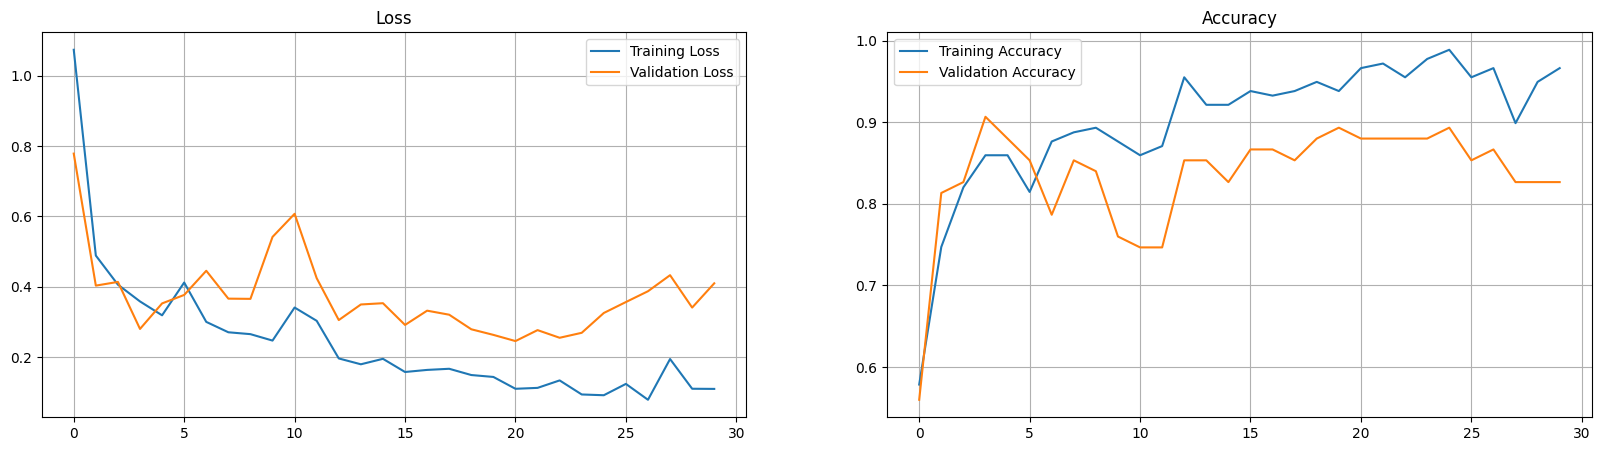

In [15]:
# plotting training / validation history
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(data.loss, label='Training Loss')
plt.plot(data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(data.accuracy, label='Training Accuracy')
plt.plot(data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

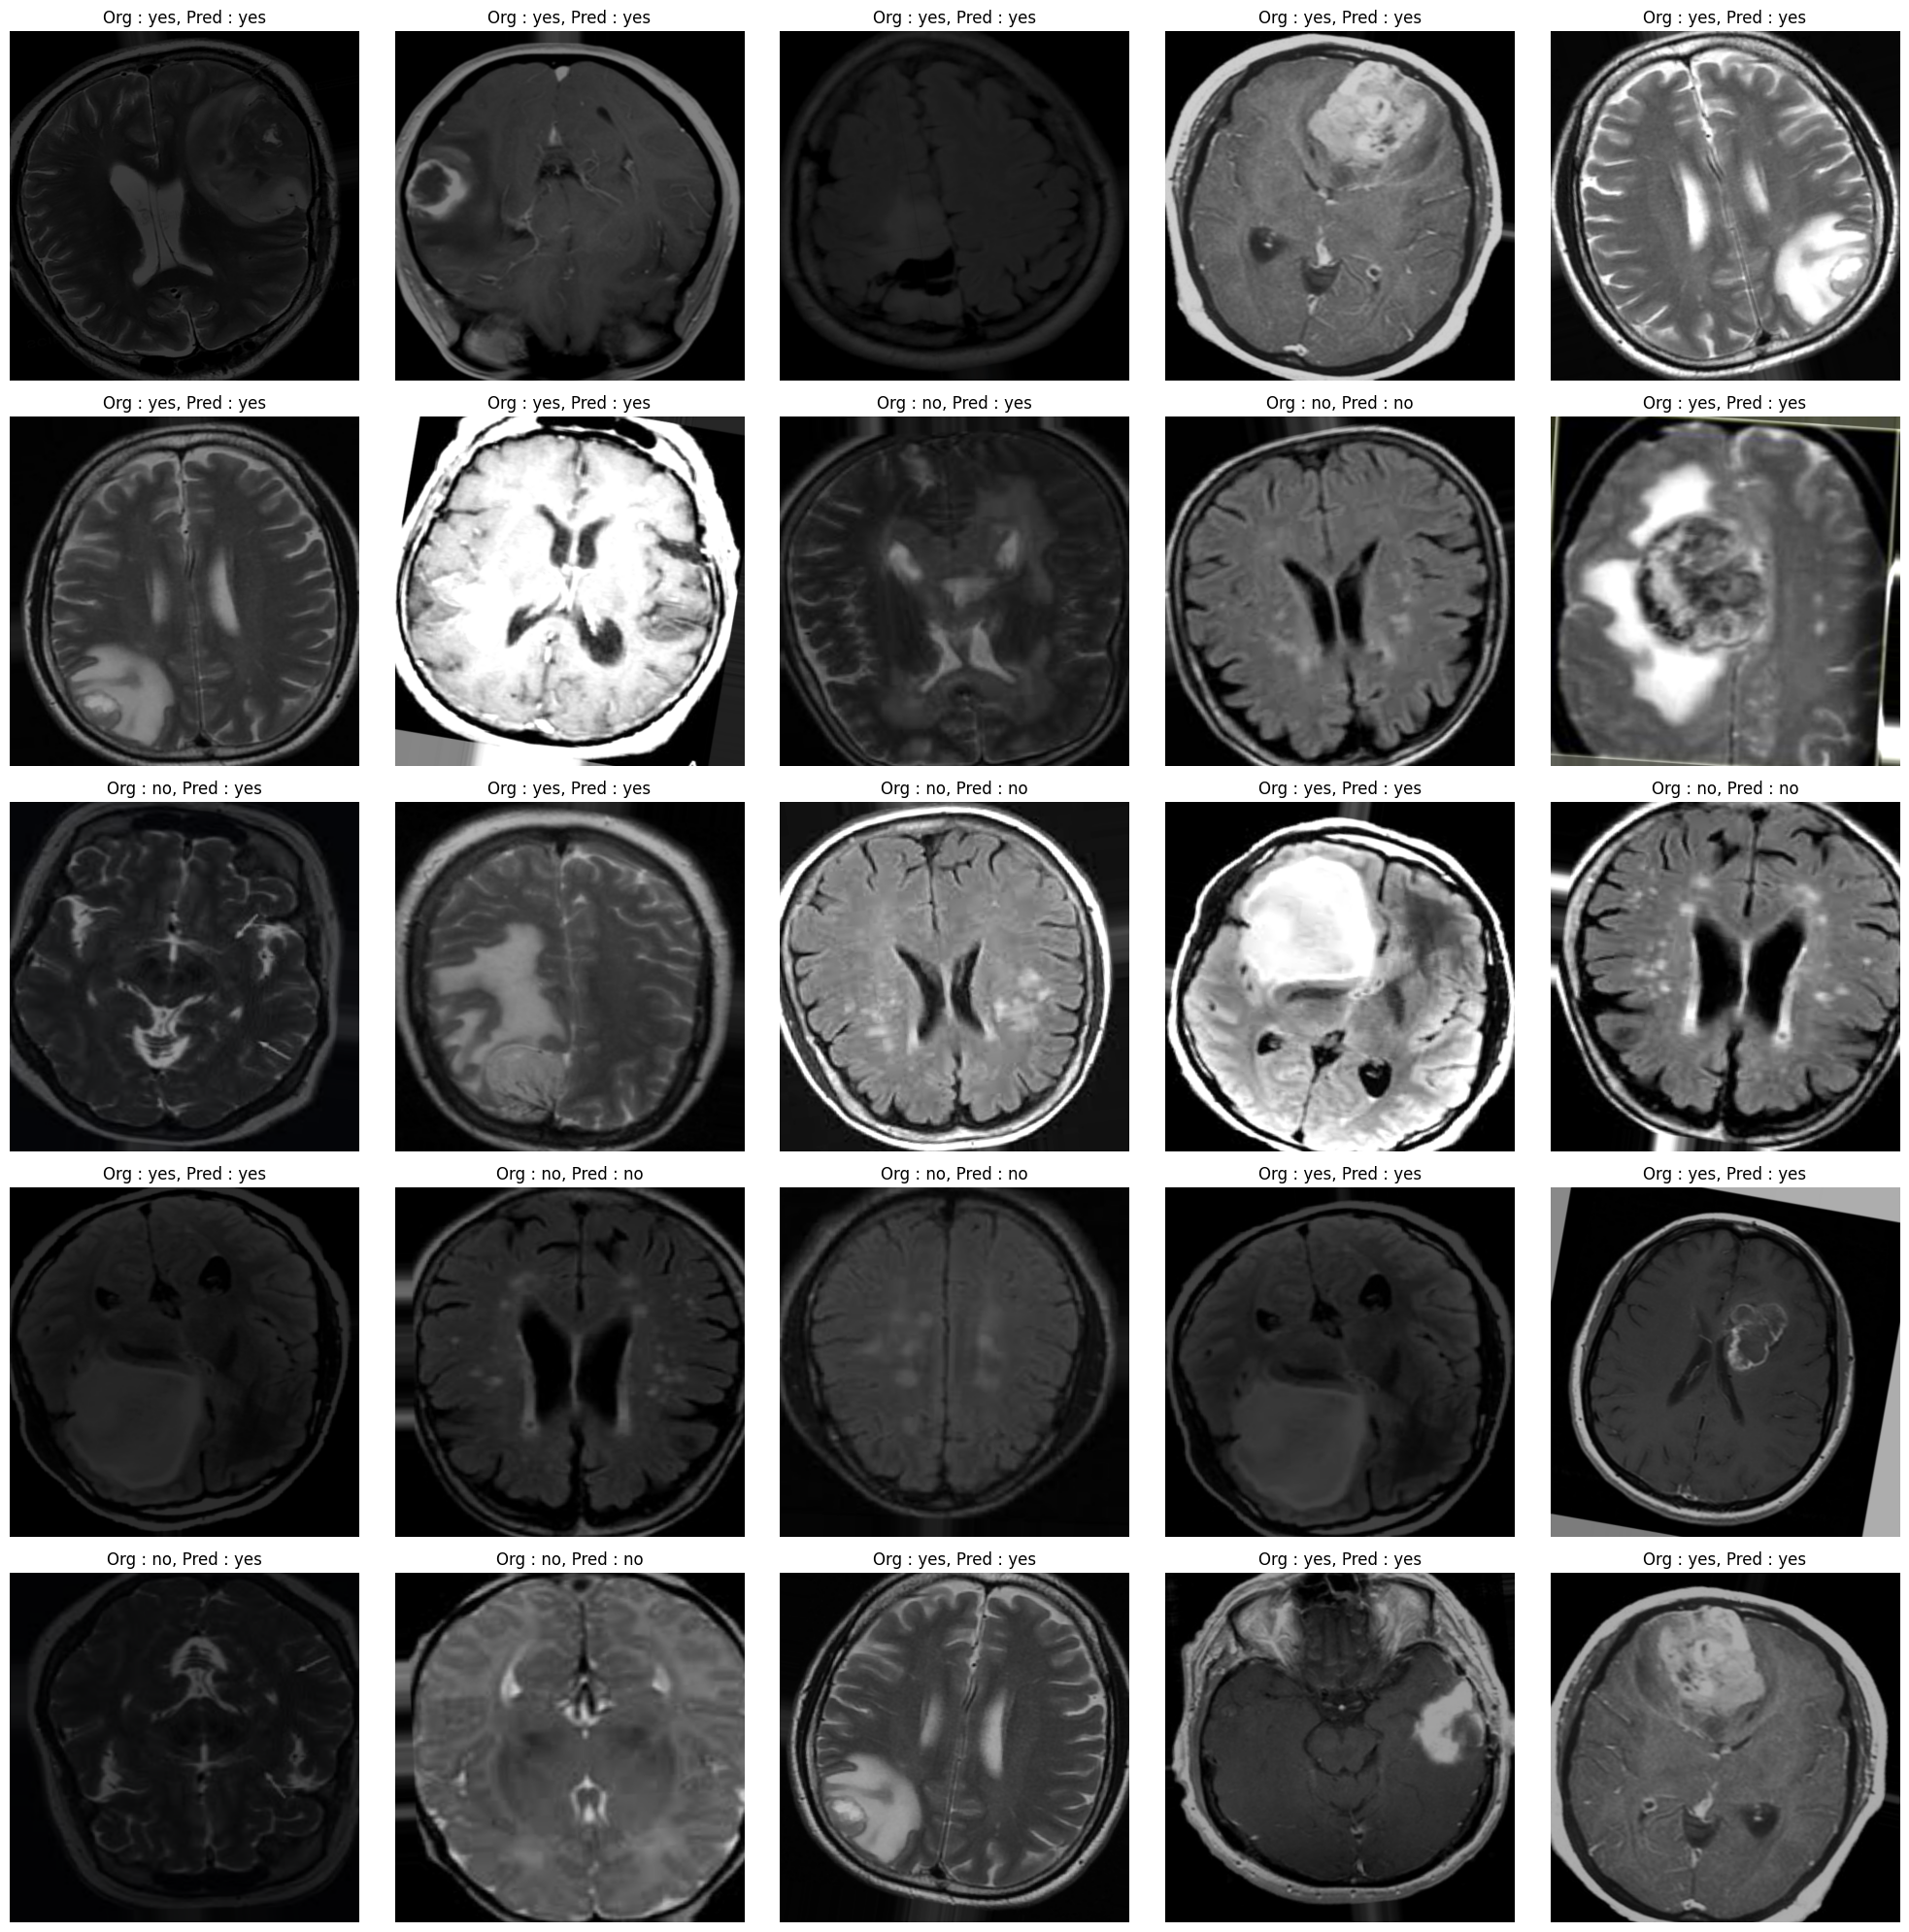

In [16]:
# plotting predictions
show_images(model=model, data=validation)